ADF Statistic: -3.183192251191782
p-value: 0.02097842525600371
Critical Values:
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


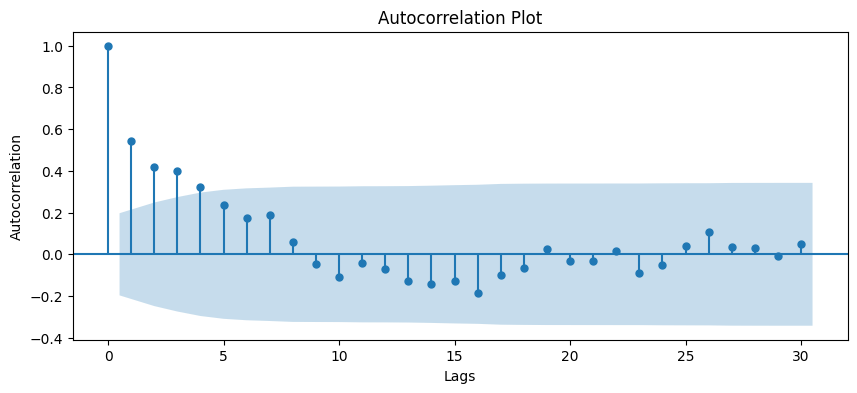

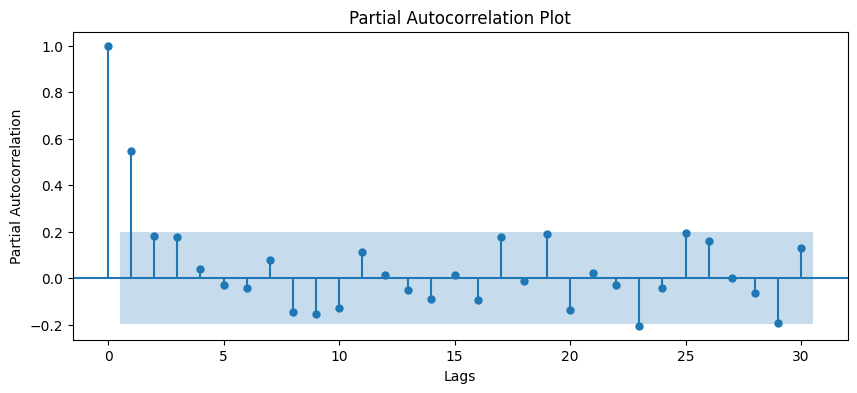

Best fit lambda: 20.02021484375004
Standard Error: [0.01433848]
Confidence Interval (95%): [19.99211142] - [20.04831827]
Shapiro-Wilk test - Test Statistic: 0.9125058650970459
Shapiro-Wilk test - p-value: 6.3391953517566435e-06
Ljung-Box test (lag 20) - Statistic: 15.205034748854722
Ljung-Box test (lag 20) - p-value: 0.7645576885620793
Box-Pierce test (lag 20) - Statistic: 13.065218679103474
Box-Pierce test (lag 20) - p-value: 0.8745682936638344
Shapiro-Wilk test - Statistic: 0.9718077778816223
Shapiro-Wilk test - p-value: 0.031826287508010864


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from scipy.stats import poisson
from scipy.stats import poisson, shapiro
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
# 读取Excel表格数据
data = pd.read_excel("path")

# 获取地震发生次数列的数据
earthquake_counts = data["number"].values

# 进行ADF检验
result = adfuller(earthquake_counts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")
###

# 绘制自相关图
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(earthquake_counts, ax=ax, lags=30)
ax.set_xlabel("Lags")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Plot")

# 绘制偏自相关图
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(earthquake_counts, ax=ax, lags=30)
ax.set_xlabel("Lags")
ax.set_ylabel("Partial Autocorrelation")
ax.set_title("Partial Autocorrelation Plot")

plt.show()
###



# 定义负的对数似然函数
def neg_log_likelihood(lam):
    # 计算负对数似然值
    log_likelihood = -sum(poisson.logpmf(earthquake_counts, lam))
    return log_likelihood

# 使用最小化方法找到使负对数似然最小的参数值
result = minimize(neg_log_likelihood, x0=[1.0], method='Nelder-Mead')
best_fit_lambda = result.x[0]

# 计算残差
residuals = earthquake_counts - poisson.pmf(earthquake_counts, best_fit_lambda) * sum(earthquake_counts)

# 通过数值方法计算Hessian矩阵的逆矩阵的近似值
eps = np.sqrt(np.finfo(float).eps)
hessian = (neg_log_likelihood(best_fit_lambda + eps) - 2 * neg_log_likelihood(best_fit_lambda) + neg_log_likelihood(best_fit_lambda - eps)) / eps**2
cov_matrix = np.linalg.pinv(np.atleast_2d(hessian))
se = np.sqrt(np.diag(cov_matrix))

# 计算置信区间
alpha = 0.05  # 置信水平为95%
z_value = 1.96  # 对应于95%置信水平的Z值
lower_ci = best_fit_lambda - z_value * se
upper_ci = best_fit_lambda + z_value * se

# 进行正态性检验
test_statistic, p_value = shapiro(residuals)

print("Best fit lambda:", best_fit_lambda)
print("Standard Error:", se)
print("Confidence Interval (95%):", lower_ci, "-", upper_ci)
print("Shapiro-Wilk test - Test Statistic:", test_statistic)
print("Shapiro-Wilk test - p-value:", p_value)


###
# 拟合ARIMA模型
p = 1  # 替换为实际的p值
d = 0  # 替换为实际的d值
q = 1  # 替换为实际的q值
model = ARIMA(earthquake_counts, order=(p, d, q))
model_fit = model.fit()

# 获取模型的残差序列
residuals = model_fit.resid

# 进行Ljung-Box检验
lb_test = acorr_ljungbox(residuals, lags=[20], boxpierce=True, return_df=True)  # 设置return_df为True
lb_statistic = lb_test["lb_stat"][20]  # 从DataFrame中获取统计量
lb_p_value = lb_test["lb_pvalue"][20]  # 从DataFrame中获取p值
bp_statistic = lb_test["bp_stat"][20]  # 从DataFrame中获取统计量
bp_p_value = lb_test["bp_pvalue"][20]  # 从DataFrame中获取p值
print("Ljung-Box test (lag 20) - Statistic:", lb_statistic)
print("Ljung-Box test (lag 20) - p-value:", lb_p_value)
print("Box-Pierce test (lag 20) - Statistic:", bp_statistic)
print("Box-Pierce test (lag 20) - p-value:", bp_p_value)

# 进行Shapiro-Wilk检验
shapiro_statistic, shapiro_p_value = shapiro(residuals)
print("Shapiro-Wilk test - Statistic:", shapiro_statistic)
print("Shapiro-Wilk test - p-value:", shapiro_p_value)
